In [1]:
import glob, os
test_data_files = []
for file in glob.glob("/Users/mohamedr/projects/rules/nmt_scalp_eeg_dataset/*/eval/*.edf"):
    test_data_files.append(file)
print(len(test_data_files))

train_data_files = []
for file in glob.glob("/Users/mohamedr/projects/rules/nmt_scalp_eeg_dataset/*/train/*.edf"):
    train_data_files.append(file)
print(len(train_data_files))

185
2232


In [2]:
!cat /Users/mohamedr/projects/rules/nmt_scalp_eeg_dataset/DataStats.py

# -*- coding: utf-8 -*-
"""
Created on Thu Jul 15 15:34:27 2021

@author: hasan
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

df = pd.read_csv('Labels.csv')
male_norm = df.query('gender=="male" and label=="normal"')
male_abnm = df.query('gender=="male" and label=="abnormal"')
female_norm = df.query('gender=="female" and label=="normal"')
female_abnm = df.query('gender=="female" and label=="abnormal"')
n_bins = 21
d_labels = ['Normal', 'Abnormal']

'''-------------------Calculate Stats-------------------'''
mean_age = df.groupby(['gender']).mean()
std_age = df.groupby(['gender']).std()

mean_age_male = mean_age.loc['male']['age']
std_age_male = std_age.loc['male']['age']
n_male = len(male_norm) + len(male_abnm)
p_male_norm = (len(male_norm)/n_male)*100
p_male_abnm = 100 - p_male_norm

mean_age_female = mean_age.loc['female']['age']
std_age_female = std_age.loc['female']['age']
n_female = len(female_norm) + len(femal

In [3]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.modules.module import Module
from sklearn.preprocessing import OneHotEncoder

/Users/mohamedr/opt/anaconda3/envs/xai/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import mne
import numpy as np

data = mne.io.read_raw(file, verbose=False, preload=True)

data.filter(l_freq=0.5, h_freq=40, verbose=False)#.resample(sfreq=100)
data = mne.make_fixed_length_epochs(data, duration=1, overlap=0, verbose=False)
ch_names = data.ch_names
data = data.get_data()
data.shape

Using data from preloaded Raw for 846 events and 200 original time points ...
0 bad epochs dropped


(846, 21, 200)

In [5]:
import mne
from tqdm import tqdm
from statsmodels.tsa.stattools import grangercausalitytests
import random
import numpy as np
from scipy.signal import savgol_filter
from scipy import signal
import cv2
from numpy import *
from scipy.stats import iqr
from scipy.integrate import simps
from scipy.stats import entropy
from scipy.signal import medfilt
from scipy.stats import differential_entropy, norm
from scipy import fftpack
import antropy as ant


def calcGrangerCausality(eegData,ii,jj):
    #eegData = np.diff(eegData)
    gc_avg = []
    for epoch_idx, epoch in enumerate(eegData):
        if epoch_idx%3 == 0:
            X = np.vstack([epoch[ii,:],epoch[jj,:]]).T
            gc = grangercausalitytests(X, 1, addconst=True, verbose=False)[1][0]['ssr_ftest'][1]
            gc_avg.append(gc)
    gc_avg = np.mean(gc_avg)
    return gc_avg
    
def get_label(file):
    label = file.split("/")[-3]
    if label == "normal":
        return [0]
    elif label == "abnormal":
        return [1]

    
def lyapunov(x):
    return np.mean(np.log(np.abs(np.gradient(x))))


def build_data(raw_data, cal_conn=True,  bands=False):
    
    eeg_data = []
    labels = []
    lengths = []
    groups = []
    i = 0
    fs = 100
    win = 4 * fs
    
    data_features = []
    data_labels = []
    data_graphs = []
    
    for file in tqdm(raw_data):
        
        #get label
        label = get_label(file)
        data_labels.append(label)
        
        #node features
        sample_features = []
        data = mne.io.read_raw(file, verbose=False, preload=True)
        ch_names = data.ch_names
        #data.resample(sfreq=100)
        data.filter(l_freq=0.5, h_freq=40, verbose=False).resample(sfreq=fs)
        data_epochs = mne.make_fixed_length_epochs(data, duration=1, overlap=0, verbose=False)
        data = data.get_data()#[:, :20000]
        data_epochs = data_epochs.get_data()
        if data_epochs.shape[0] > 50:
            data_epochs = data_epochs[:50]
        
        if cal_conn:
            gc = []
            for i in range(21):
                gc1 = []
                for j in range(21):
                    gc1.append(calcGrangerCausality(data_epochs, i, j))
                gc.append(gc1)
        
            gc1 = (np.array(gc) + np.array(gc).T)/2
            gc2 = (np.array(gc) - np.array(gc).T)/2
            data_graphs.append([gc1, gc2])    
        
        
        ch_features = []    
        # freq domain features
        # delta (0.5–4 Hz), theta (4–8 Hz), alpha (8–13 Hz), beta (13–30 Hz), and gamma (30–... Hz).
        freq_ranges = [[0.5, 4], [4, 8], [8, 13], [13, 30], [30, 47]]
        for ch in data:
            
            ch_features.append(differential_entropy(ch))
        
            ly = lyapunov(ch)
            ch_features.append(ly)
        
            entropy = ant.perm_entropy(ch, normalize=True)
            ch_features.append(entropy)
        
            entropy = ant.spectral_entropy(ch, sf=100, method='welch', normalize=True)
            ch_features.append(entropy)
        
            mobility = ant.hjorth_params(ch)
            ch_features.append(mobility[0])
            ch_features.append(mobility[1])
        
            zero_cross_count = ant.num_zerocross(ch)
            ch_features.append(zero_cross_count)
            
                
            
            if bands:
                # freq domain features
                for freq_band in freq_ranges:
                
                    # differential entropy
                    sos = signal.butter(10, (freq_band[0], freq_band[1]), 'bandpass', fs=1000, output='sos')
                    filtered_ch = signal.sosfilt(sos, ch) 
                    ch_features.append(differential_entropy(filtered_ch))

                    # lyapunov features
                    ch_features.append(lyapunov(filtered_ch))

                    # Permutation entropy
                    entropy = ant.perm_entropy(filtered_ch, normalize=True)
                    ch_features.append(entropy)

                    # Spectral entropy
                    entropy = ant.spectral_entropy(filtered_ch, sf=100, method='welch', normalize=True)
                    ch_features.append(entropy)

                    # Hjorth mobility and complexity
                    mobility = ant.hjorth_params(filtered_ch)
                    ch_features.append(mobility[0])
                    ch_features.append(mobility[1])

                    corr = np.correlate(filtered_ch, filtered_ch)
                    ch_features.append(corr[0])

                    # Number of zero-crossings
                    zero_cross_count = ant.num_zerocross(filtered_ch)
                    ch_features.append(zero_cross_count)

                    # power spectrum
                    freqs, psd = signal.welch(ch, sf, nperseg=win)
                    idx_freq_band = np.logical_and(freqs >= freq_band[0], freqs < freq_band[1])
                    # Frequency resolution
                    freq_res = freqs[1] - freqs[0]  # = 1 / 4 = 0.25
                    # Compute the absolute power by approximating the area under the curve
                    band_power = simps(psd[idx_freq_band], dx=freq_res)
                    #power_band_.append(band_power)
                    ch_features.append(band_power)
                
            
            sample_features.append(ch_features)
            ch_features = []
        
            
        data_features.append(sample_features)
        
    data_features = np.array(data_features)
    data_labels = np.array(data_labels)
    data_graphs = np.array(data_graphs)
    
    return data_features, data_graphs, data_labels

In [6]:
%%capture
np.random.seed(42)
train_X, train_graphs, train_y = build_data(train_data_files)
test_X, test_graphs, test_y = build_data(test_data_files)

In [9]:
test_X.shape, train_X.shape, train_graphs.shape, test_y.shape, train_y.shape, test_graphs.shape

((185, 21, 7),
 (2232, 21, 7),
 (2232, 21, 21),
 (185, 1),
 (2232, 1),
 (185, 21, 21))

In [29]:
#np.save("../NMT_features/conn_data/gc/train_X.npy", train_X)
#np.save("../NMT_features/conn_data/gc/test_X.npy", test_X)
#np.save("../NMT_features/conn_data/gc/train_y.npy", train_y)
#np.save("../NMT_features/conn_data/gc/test_y.npy", test_y)
#np.save("../NMT_features/conn_data/gc/train_graphs.npy", train_graphs)
#np.save("../NMT_features/conn_data/gc/test_graphs.npy", test_graphs)

In [7]:
import copy
from tqdm import tqdm

def uniform_all_data(train_graphs, test_graphs):
    out_train = copy.deepcopy(train_graphs)
    out_test = copy.deepcopy(test_graphs)

    min_A = train_graphs.min()
    max_A = train_graphs.max()
    out_train = (train_graphs - min_A)/(max_A - min_A)
    out_test = (test_graphs - min_A)/(max_A - min_A)

    return out_train, out_test


def uniform(graphs):
    out = copy.deepcopy(graphs)

    min_A = graphs.min()
    max_A = graphs.max()
    out = (graphs - min_A)/(max_A - min_A)

    return out

import torch
import copy

from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.base import TransformerMixin,BaseEstimator
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
import copy

def data_loader(features, graphs, labels, device, batch_size, shuffle=True):
    features, graphs, labels = torch.Tensor(features), torch.Tensor(graphs), torch.Tensor(labels)
    data = torch.utils.data.TensorDataset(features, graphs, labels)
    del features
    del labels
    data_iter = torch.utils.data.DataLoader(data, batch_size, shuffle=shuffle)
    del data
    return data_iter

def standardize_data(train_X, test_X):
 
    train_X_std = copy.deepcopy(train_X)
    test_X_std = copy.deepcopy(test_X)
    
    for i in tqdm(range(train_X.shape[1])):
        for j in range(train_X.shape[2]):
            min_ = np.min(train_X[:, i, j])
            max_ = np.max(train_X[:, i, j]) #+ 0.000000000000001
        
            train_X_std[:, i, j] = (train_X[:, i, j] - min_)/(max_ - min_)    
            test_X_std[:, i, j] = (test_X[:, i, j] - min_)/(max_ - min_)

    return train_X_std, test_X_std

In [8]:
train_X = np.load("../NMT_features/conn_data/gc/train_X.npy")
test_X = np.load("../NMT_features/conn_data/gc/test_X.npy")
train_y = np.load("../NMT_features/conn_data/gc/train_y.npy")
test_y = np.load("../NMT_features/conn_data/gc/test_y.npy")
train_graphs = np.load("../NMT_features/conn_data/gc/train_graphs.npy")
test_graphs = np.load("../NMT_features/conn_data/gc/test_graphs.npy")

train_graphs1, test_graphs1 = uniform_all_data(train_graphs[:, 0], test_graphs[:, 0])
train_graphs2, test_graphs2 = uniform_all_data(train_graphs[:, 1], test_graphs[:, 1])

train_graphs = np.sum((train_graphs1, train_graphs2), axis=0)
test_graphs = np.sum((test_graphs1, test_graphs2), axis=0)
#train_graphs, test_graphs = uniform_all_data(train_graphs, test_graphs)
train_X, test_X = standardize_data(train_X, test_X)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [00:00<00:00, 2367.82it/s]


In [10]:
train_X.shape, test_X.shape

((2232, 21, 7), (185, 21, 7))

In [11]:
train_X.max(), test_X.max(), train_X.min(), test_X.min()

(1.0, 1.2958320914403714, 0.0, -0.12373540501103679)

In [12]:
train_graphs.max(), train_graphs.min(), test_graphs.max(), test_graphs.min()

(1.5, 0.4961430763304524, 1.5, 0.4979749610349427)

In [13]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score, precision_score, recall_score, auc, roc_auc_score

def evaluate_model(model, loss_func, data_iter):
    model.eval()
    loss_sum, n = 0, 0
    with torch.no_grad():
        for x, A, y in data_iter:
            x = x.float()
            A = A.float()
            y_pred = model(x, A)
            #y = y.long()
            #y = y.float()
            loss = loss_func(y_pred,y)
            loss_sum += loss.item()
            n += 1
        return loss_sum / n
    
def cal_accuracy(model, data_iter):
    ytrue = []
    ypreds = []
    y_score = []
    model.eval()
    with torch.no_grad():
        for x, A, y in data_iter:
            x = x.float()
            A = A.float()
            yhat = model(x, A)
            yhat_labels = np.argmax(yhat, -1)
            y_labels = np.argmax(y, -1)
        
            
            y_score.extend(np.max(F.softmax(yhat, dim=1).numpy(), -1))
            ytrue.extend(list(y_labels.numpy()))
            ypreds.extend([int(yhat_i) for yhat_i in yhat_labels])
    
    return (accuracy_score(ytrue, ypreds), 
            confusion_matrix(ytrue, ypreds), 
            precision_score(ytrue, ypreds,  average='binary', zero_division=0), 
            recall_score(ytrue, ypreds,  average='binary', zero_division=0),
            f1_score(ytrue, ypreds,  average='binary', zero_division=0))

# Training Neural Network using GC as adjacency matrix

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool, global_max_pool
import networkx as nx


def normalize_A(A):
    norm = []
    A1 = (A + A.T)/2
    A2 = (A - A.T)/2
    A1 = uniform(A1)
    A2 = uniform(A2)
    for graph_feat in [A1, A2]:
        graph_feat = nx.Graph(graph_feat)
        norm.append(nx.normalized_laplacian_matrix(graph_feat).toarray())
    
    return norm


def normalize_all_A(A):
    
    A = A.detach().numpy()
    all_A = []
    for adj in A:
        all_A.append(normalize_A(adj))
    all_A = np.array(all_A)
    all_A = torch.tensor(all_A)
    return all_A


class ChebNetConv(nn.Module):
    def __init__(self, in_features, out_features, k):
        super(ChebNetConv, self).__init__()

        self.K = k
        self.linear = nn.Linear(in_features * k, out_features)

    def forward(self, x: torch.Tensor, laplacian: torch.sparse_coo_tensor):
        x = self.__transform_to_chebyshev(x, laplacian)
        x = self.linear(x)
        
        return x

    def __transform_to_chebyshev(self, x, laplacian):
        cheb_x = x.unsqueeze(2)
        x0 = x
        if self.K > 1:
            x1 = torch.matmul(laplacian, x0)
            cheb_x = torch.cat((cheb_x, x1.unsqueeze(2)), 2)
            for _ in range(2, self.K):
                x2 = 2 * torch.matmul(laplacian, x1) - x0
                cheb_x = torch.cat((cheb_x, x2.unsqueeze(2)), 2)
                x0, x1 = x1, x2
        cheb_x = cheb_x.reshape(cheb_x.shape[0], cheb_x.shape[1], cheb_x.shape[2]*cheb_x.shape[3])
        return cheb_x

    
import torch.nn.functional as F


class ChebNetGCN(nn.Module):
    def __init__(self, input_size, hidden_size, num_electrodes, out_channels, 
                 num_classes, num_hidden_layers=2, dropout=0, residual=False, k=2):
        super(ChebNetGCN, self).__init__()

        self.dropout = dropout
        self.residual = residual

        self.input_conv = ChebNetConv(input_size, hidden_size, k)
        self.hidden_convs = nn.ModuleList([ChebNetConv(hidden_size, hidden_size, k) for _ in range(num_hidden_layers)])
        self.output_conv = ChebNetConv(hidden_size, out_channels, k)
        self.BN1 = nn.BatchNorm1d(out_channels*2)
        self.fc = nn.Linear(out_channels*2, num_classes)
        
    def forward(self, x: torch.Tensor, A: torch.sparse_coo_tensor, edge_weight=None):
        if edge_weight is not None:
            A = edge_weight * A
            
        laplacians = normalize_all_A(A)
        
        laplacian1,laplacian2 = laplacians[:, 0].float(), laplacians[:, 1].float()
        #print(laplacian1.shape,laplacian2.shape, laplacian1[0])
        #laplacian1 = laplacian1 + laplacian2
        x1 = F.relu(self.input_conv(x, laplacian1))
        x2 = F.relu(self.input_conv(x, laplacian2))
        #print(x.shape)
        for conv in self.hidden_convs:
            if self.residual:
                x1 = F.relu(conv(x1, laplacian1)) + x1
                x2 = F.relu(conv(x2, laplacian2)) + x2
            else:
                x1 = F.relu(conv(x1, laplacian1))
                x2 = F.relu(conv(x2, laplacian2))
        #print(x.shape)        
        #x1 = F.dropout(x1, p=self.dropout, training=self.training)
        x1 = self.output_conv(x1, laplacian1)
        #x2 = F.dropout(x2, p=self.dropout, training=self.training)
        x2 = self.output_conv(x2, laplacian2)
        #print(x.shape)
        x1 = x1.squeeze()
        #x = x1
        x2 = x2.squeeze()
        #print(x1.shape,x2.shape)
        x = torch.cat((x1, x2), dim=-1)
        #x = x1 + x2
        #print(x.shape)
        batch =None
        x = global_mean_pool(x, batch)
        #print(x.shape)
        x = self.BN1(x)
        x = self.fc(x)
        #print(x.shape)
        return x

In [633]:
from tqdm import tqdm
import torch.nn as nn
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import torch
#from model import ChebNetGCN

NUM_EPOCHS = 1000
NUM_CHANNELS = 21
NUM_CLASSES = 2
NUM_NODE_FEATURES = 7
BATCH_SIZE = 128
DEVICE = torch.device("cpu")

loss_func = nn.BCEWithLogitsLoss()

all_train_losses = []
all_val_losses = []
all_train_f1 = []
all_val_f1 = []

skf = KFold(n_splits=5, shuffle=True)
skf.get_n_splits(train_X, train_y)

for i, (train_index, val_index) in enumerate(skf.split(train_X, train_y)):
    
    model = ChebNetGCN(NUM_NODE_FEATURES, 32, NUM_CHANNELS, 32, NUM_CLASSES)

    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)

    train_X_subset = train_X[train_index]
    train_y_subset = train_y[train_index]
    train_graphs_subset = train_graphs[train_index]
    val_X = train_X[val_index]
    val_y = train_y[val_index]
    val_graphs_subset = train_graphs[val_index]

    encoder = OneHotEncoder()
    train_y_subset = encoder.fit_transform(train_y_subset).toarray()
    val_y = encoder.transform(val_y).toarray()

    batch_size = 128
    train_iter = data_loader(train_X_subset ,train_graphs_subset, train_y_subset, DEVICE, BATCH_SIZE, shuffle=True)
    val_iter = data_loader(val_X, val_graphs_subset, val_y, DEVICE, BATCH_SIZE, shuffle=False)

    kfold_train_loss = []
    kfold_val_loss = []
    kfold_train_f1 = []
    kfold_val_f1 = []
    for epoch in tqdm(range(1, NUM_EPOCHS + 1)):
        loss_sum, n = 0.0, 0
        model.train()
        for t, (x, A, y) in enumerate(train_iter):
            optimizer.zero_grad()
            x = x.float()
            A = A.float()
            y_pred = model(x, A)
            loss = loss_func(y_pred, y)
            loss_sum += loss#.item()
            loss.backward()
            optimizer.step()

        train_loss = evaluate_model(model, loss_func, train_iter)
        val_loss = evaluate_model(model, loss_func, val_iter)
        train_f1 = cal_accuracy(model, train_iter)[-1]
        val_f1 = cal_accuracy(model, val_iter)[-1]
        kfold_train_loss.append(train_loss)
        kfold_val_loss.append(val_loss)
        kfold_train_f1.append(train_f1)
        kfold_val_f1.append(val_f1)

    all_train_losses.append(kfold_train_loss)
    all_val_losses.append(kfold_val_loss)
    all_train_f1.append(kfold_train_f1)
    all_val_f1.append(kfold_val_f1)

100%|█████████████████████████████████████████████████████████████| 1000/1000 [16:36<00:00,  1.00it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


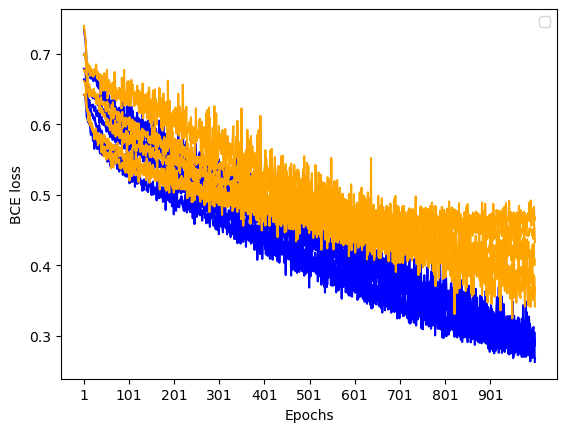

In [634]:
import matplotlib.pyplot as plt

all_val_losses = np.moveaxis(np.array(all_val_losses), 0, 1)
all_train_losses = np.moveaxis(np.array(all_train_losses), 0, 1)
plt.plot(all_train_losses, color='blue')
plt.plot(all_val_losses, color='orange')
plt.xlabel("Epochs")
plt.xticks(range(0, 1000, 100), range(1, 1001, 100))
plt.ylabel("BCE loss")
plt.legend(loc="upper right")
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


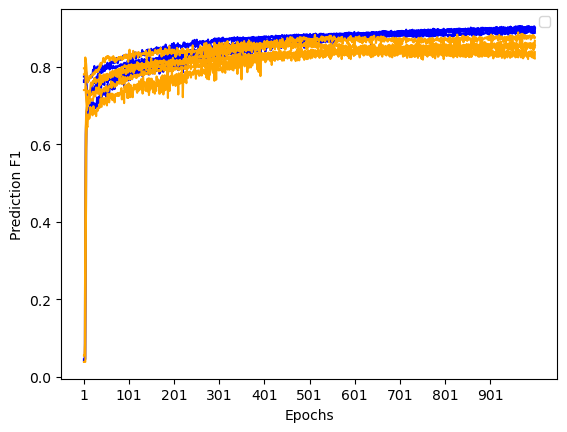

In [635]:
all_val_f1 = np.moveaxis(np.array(all_val_f1), 0, 1)
all_train_f1 = np.moveaxis(np.array(all_train_f1), 0, 1)
plt.plot(all_train_f1, color='blue')
plt.plot(all_val_f1, color='orange')
plt.xlabel("Epochs")
plt.xticks(range(0, 1000, 100), range(1, 1001, 100))
plt.ylabel("Prediction F1")
plt.legend(loc="upper right")
plt.show()

In [24]:
#%%capture
print("Training Model....")
#from model import ChebNetGCN

NUM_EPOCHS = 85
NUM_CHANNELS = 21
NUM_CLASSES = 2
NUM_NODE_FEATURES = 7
BATCH_SIZE = 256
DEVICE = torch.device("cpu")

model = ChebNetGCN(NUM_NODE_FEATURES, 64, NUM_CHANNELS, 64, NUM_CLASSES)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
encoder = OneHotEncoder()
train_y_ohe = encoder.fit_transform(train_y).toarray()
test_y_ohe = encoder.fit_transform(test_y).toarray()
    
train_iter = data_loader(train_X , train_graphs, train_y_ohe, DEVICE, BATCH_SIZE, shuffle=True)
test_iter = data_loader(test_X , test_graphs, test_y_ohe, DEVICE, BATCH_SIZE, shuffle=False)
  
for epoch in tqdm(range(1, NUM_EPOCHS + 1)):
    loss_sum, n = 0.0, 0
    model.train()
    for t, (x, A, y) in enumerate(train_iter):
        optimizer.zero_grad()
        x = x.float()
        A = A.float()
        y_pred = model(x, A)
        loss = loss_func(y_pred, y)
        loss_sum += loss
        loss.backward()
        optimizer.step()

Training Model....


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 85/85 [08:18<00:00,  5.86s/it]


In [25]:
test_acc = cal_accuracy(model, test_iter)
print("Accuracy: ", test_acc[0])
print("Precision: ", test_acc[2])
print("Recall: ", test_acc[3])
print("F1: ", test_acc[4])
print("Confusion Matrix: ", test_acc[1])

Accuracy:  0.8432432432432433
Precision:  0.9295774647887324
Recall:  0.7333333333333333
F1:  0.8198757763975155
Confusion Matrix:  [[90  5]
 [24 66]]


## Model Stability

here we run 20 models using different seeds and record the evaluation metrics to check if the model is reliable and provides consistent results.

In [26]:
#%%capture
print("Training Model....")
import random
#from model import ChebNetGCN
NUM_EPOCHS = 85
NUM_CHANNELS = 21
NUM_CLASSES = 2
NUM_NODE_FEATURES = 7
BATCH_SIZE = 256
DEVICE = torch.device("cpu")

test_accuaries = []
NUM_MODELS = 20

for model_idx in tqdm(range(NUM_MODELS)):
    seed = random.randint(0, 100000)
    torch.manual_seed(seed)
    model = ChebNetGCN(NUM_NODE_FEATURES, 64, NUM_CHANNELS, 64, NUM_CLASSES)
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-5)
    encoder = OneHotEncoder()
    train_y_ohe = encoder.fit_transform(train_y).toarray()
    test_y_ohe = encoder.fit_transform(test_y).toarray()

    train_iter = data_loader(train_X , train_graphs, train_y_ohe, DEVICE, BATCH_SIZE, shuffle=True)
    test_iter = data_loader(test_X , test_graphs, test_y_ohe, DEVICE, BATCH_SIZE, shuffle=False)

    for epoch in range(1, NUM_EPOCHS + 1):
        loss_sum, n = 0.0, 0
        model.train()
        for t, (x, A, y) in enumerate(train_iter):
            optimizer.zero_grad()
            x = x.float()
            A = A.float()
            y_pred = model(x, A)
            loss = loss_func(y_pred, y)
            loss_sum += loss
            loss.backward()
            optimizer.step()
            
    test_acc = cal_accuracy(model, test_iter)
    test_accuaries.append([test_acc[0], test_acc[2], test_acc[3], test_acc[4]])
test_accuaries = np.array(test_accuaries)

Training Model....


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [3:44:53<00:00, 674.70s/it]


In [27]:
print("Accuracy: ", test_accuaries[:, 0].mean(), ", ", test_accuaries[:, 0].std())
print("Precision: ", test_accuaries[:, 1].mean(), ", ", test_accuaries[:, 1].std())
print("Recall: ", test_accuaries[:, 2].mean(), ", ", test_accuaries[:, 2].std())
print("F1: ", test_accuaries[:, 3].mean(), ", ", test_accuaries[:, 3].std())

Accuracy:  0.8410810810810811 ,  0.01921771765906074
Precision:  0.9279910962566253 ,  0.01893060282467018
Recall:  0.7305555555555556 ,  0.04272724287794169
F1:  0.8166494786032441 ,  0.02636012756754499


Here we record the std and means of the accuracies

## Corr

In [28]:
import numpy as np

def build_graphs(raw_data):
    
    fs = 100
    
    data_graphs = []
    
    for file in tqdm(raw_data):
        
        data = mne.io.read_raw(file, verbose=False, preload=True)
        ch_names = data.ch_names
        #data.resample(sfreq=100)
        data.filter(l_freq=0.5, h_freq=47, verbose=False)
        #data = mne.make_fixed_length_epochs(data, duration=5, overlap=1, verbose=False)
        data = data.get_data()*1e6
          
        corr = []
        for i in range(21):
            corr1 = []
            for j in range(21):
                corr1.append(np.correlate(data[i], data[j])[0])
            corr.append(corr1)
        data_graphs.append(corr)    
        
    data_graphs = np.array(data_graphs)
    
    return data_graphs

train_corr_graphs = build_graphs(train_data_files)
test_corr_graphs = build_graphs(test_data_files)

 45%|█████████████████████████████████████████████████████▊                                                                  | 1001/2232 [01:37<01:54, 10.79it/s]/var/folders/jh/bl76wbz94n3727gszxkh079h0000gr/T/ipykernel_6326/1949718194.py:14: RuntimeWarning: filter_length (1321) is longer than the signal (923), distortion is likely. Reduce filter length or filter a longer signal.
  data.filter(l_freq=0.5, h_freq=47, verbose=False)
 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                 | 1914/2232 [03:03<00:31, 10.10it/s]/var/folders/jh/bl76wbz94n3727gszxkh079h0000gr/T/ipykernel_6326/1949718194.py:14: RuntimeWarning: filter_length (1321) is longer than the signal (738), distortion is likely. Reduce filter length or filter a longer signal.
  data.filter(l_freq=0.5, h_freq=47, verbose=False)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1

In [31]:
#np.save("../NMT_features/conn_data/corr/train_graphs.npy", train_corr_graphs)
#np.save("../NMT_features/conn_data/corr/test_graphs.npy", test_corr_graphs)

train_graphs = np.load("../NMT_features/conn_data/corr/train_graphs.npy")
test_graphs = np.load("../NMT_features/conn_data/corr/test_graphs.npy")

In [32]:
import copy

def uniform(train_graphs, test_graphs):
    out_train = copy.deepcopy(train_graphs)
    out_test = copy.deepcopy(test_graphs)

    min_A = train_graphs.min()
    max_A = train_graphs.max()
    out_train = (train_graphs - min_A)/(max_A - min_A)
    out_test = (test_graphs - min_A)/(max_A - min_A)

    return out_train, out_test

train_graphs, test_graphs = uniform(train_corr_graphs, test_corr_graphs)

In [33]:
train_graphs, test_graphs = uniform(train_graphs, test_graphs)

In [35]:
import networkx as nx
test_graphs_normalized = []
train_graphs_normalized = []

for graph in test_graphs:
    graph = nx.Graph(graph)
    test_graphs_normalized.append(nx.normalized_laplacian_matrix(graph).toarray())
for graph in train_graphs:
    graph = nx.Graph(graph)
    train_graphs_normalized.append(nx.normalized_laplacian_matrix(graph).toarray())

train_graphs = np.array(train_graphs_normalized)  
test_graphs = np.array(test_graphs_normalized)  

test_graphs.min(), test_graphs.max(), train_graphs.min(), train_graphs.max()

(-0.07324613551587447,
 0.9523798121322071,
 -0.09960731945064244,
 0.9523809258457095)

In [36]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool, global_max_pool


class ChebNetConv(nn.Module):
    def __init__(self, in_features, out_features, k):
        super(ChebNetConv, self).__init__()

        self.K = k
        self.linear = nn.Linear(in_features * k, out_features)

    def forward(self, x: torch.Tensor, laplacian: torch.sparse_coo_tensor):
        x = self.__transform_to_chebyshev(x, laplacian)
        x = self.linear(x)
        
        return x

    def __transform_to_chebyshev(self, x, laplacian):
        cheb_x = x.unsqueeze(2)
        x0 = x
        if self.K > 1:
            x1 = torch.matmul(laplacian, x0)
            cheb_x = torch.cat((cheb_x, x1.unsqueeze(2)), 2)
            for _ in range(2, self.K):
                x2 = 2 * torch.matmul(laplacian, x1) - x0
                cheb_x = torch.cat((cheb_x, x2.unsqueeze(2)), 2)
                x0, x1 = x1, x2
        cheb_x = cheb_x.reshape(cheb_x.shape[0], cheb_x.shape[1], cheb_x.shape[2]*cheb_x.shape[3])
        return cheb_x

    
import torch.nn.functional as F


class ChebNetGCN(nn.Module):
    def __init__(self, input_size, hidden_size, num_electrodes, out_channels, 
                 num_classes, num_hidden_layers=2, dropout=0, residual=False, k=2):
        super(ChebNetGCN, self).__init__()

        self.dropout = dropout
        self.residual = residual

        self.input_conv = ChebNetConv(input_size, hidden_size, k)
        self.hidden_convs = nn.ModuleList([ChebNetConv(hidden_size, hidden_size, k) for _ in range(num_hidden_layers)])
        self.output_conv = ChebNetConv(hidden_size, out_channels, k)
        self.BN1 = nn.BatchNorm1d(out_channels)
        self.fc = nn.Linear(out_channels, num_classes)
        
    def forward(self, x: torch.Tensor, laplacian: torch.sparse_coo_tensor, edge_weight=None):
        if edge_weight is not None:
            laplacian = edge_weight * laplacian
        x = F.dropout(x, p=self.dropout, training=self.training)
        #print(x.shape)
        x = F.relu(self.input_conv(x, laplacian))
        #print(x.shape)
        for conv in self.hidden_convs:
            if self.residual:
                x = F.relu(conv(x, laplacian)) + x
            else:
                x = F.relu(conv(x, laplacian))
        #print(x.shape)        
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.output_conv(x, laplacian)
        #print(x.shape)
        x = x.squeeze()
        batch =None
        x = global_mean_pool(x, batch)
        #print(x.shape)
        x = self.BN1(x)
        x = self.fc(x)
        #print(x.shape)
        return x

In [37]:
#%%capture
from tqdm import tqdm
import torch.nn as nn
from sklearn.model_selection import KFold
from sklearn.preprocessing import OneHotEncoder
import torch
#from model import ChebNetGCN


NUM_EPOCHS = 1000
NUM_CHANNELS = 21
NUM_CLASSES = 2
NUM_NODE_FEATURES = 7
BATCH_SIZE = 128
DEVICE = torch.device("cpu")

loss_func = nn.CrossEntropyLoss()

all_train_losses = []
all_val_losses = []
all_train_f1 = []
all_val_f1 = []

skf = KFold(n_splits=5, shuffle=True)
skf.get_n_splits(train_X, train_y)

print("Training Model....")
for i, (train_index, val_index) in enumerate(skf.split(train_X, train_y)):
    
    model = ChebNetGCN(NUM_NODE_FEATURES, 32, NUM_CHANNELS, 32, NUM_CLASSES)

    optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

    train_X_subset = train_X[train_index]
    train_y_subset = train_y[train_index]
    train_graphs_subset = train_graphs[train_index]
    val_X = train_X[val_index]
    val_y = train_y[val_index]
    val_graphs_subset = train_graphs[val_index]

    encoder = OneHotEncoder()
    train_y_subset = encoder.fit_transform(train_y_subset).toarray()
    val_y = encoder.transform(val_y).toarray()

    batch_size = 128
    train_iter = data_loader(train_X_subset ,train_graphs_subset, train_y_subset, DEVICE, BATCH_SIZE, shuffle=True)
    val_iter = data_loader(val_X, val_graphs_subset, val_y, DEVICE, BATCH_SIZE, shuffle=False)

    kfold_train_loss = []
    kfold_val_loss = []
    kfold_train_f1 = []
    kfold_val_f1 = []
    for epoch in tqdm(range(1, NUM_EPOCHS + 1)):
        loss_sum, n = 0.0, 0
        model.train()
        for t, (x, A, y) in enumerate(train_iter):
            optimizer.zero_grad()
            x = x.float()
            A = A.float()
            y_pred = model(x, A)
            loss = loss_func(y_pred, y)
            loss_sum += loss#.item()
            loss.backward()
            optimizer.step()

        train_loss = evaluate_model(model, loss_func, train_iter)
        val_loss = evaluate_model(model, loss_func, val_iter)
        train_f1 = cal_accuracy(model, train_iter)[-1]
        val_f1 = cal_accuracy(model, val_iter)[-1]
        kfold_train_loss.append(train_loss)
        kfold_val_loss.append(val_loss)
        kfold_train_f1.append(train_f1)
        kfold_val_f1.append(val_f1)

    all_train_losses.append(kfold_train_loss)
    all_val_losses.append(kfold_val_loss)
    all_train_f1.append(kfold_train_f1)
    all_val_f1.append(kfold_val_f1)

Training Model....


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:13<00:00,  5.16it/s]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


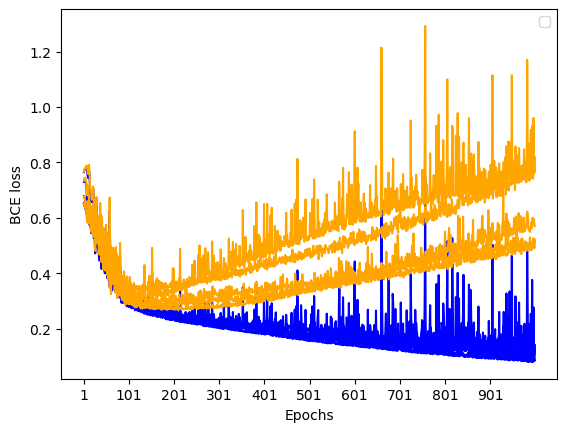

In [38]:
import matplotlib.pyplot as plt

all_val_losses = np.moveaxis(np.array(all_val_losses), 0, 1)
all_train_losses = np.moveaxis(np.array(all_train_losses), 0, 1)
plt.plot(all_train_losses, color='blue')
plt.plot(all_val_losses, color='orange')
plt.xlabel("Epochs")
plt.xticks(range(0, 1000, 100), range(1, 1001, 100))
plt.ylabel("BCE loss")
plt.legend(loc="upper right")
plt.show()

In [43]:
#%%capture
print("Training Model....")
#from model import ChebNetGCN

NUM_EPOCHS = 110
NUM_CHANNELS = 21
NUM_CLASSES = 2
NUM_NODE_FEATURES = 7
BATCH_SIZE = 128
DEVICE = torch.device("cpu")

model = ChebNetGCN(NUM_NODE_FEATURES, 32, NUM_CHANNELS, 32, NUM_CLASSES)
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
encoder = OneHotEncoder()
train_y_ohe = encoder.fit_transform(train_y).toarray()
test_y_ohe = encoder.fit_transform(test_y).toarray()
    
train_iter = data_loader(train_X , train_graphs, train_y_ohe, DEVICE, BATCH_SIZE, shuffle=True)
test_iter = data_loader(test_X , test_graphs, test_y_ohe, DEVICE, BATCH_SIZE, shuffle=False)
  
for epoch in tqdm(range(1, NUM_EPOCHS + 1)):
    loss_sum, n = 0.0, 0
    model.train()
    for t, (x, A, y) in enumerate(train_iter):
        optimizer.zero_grad()
        x = x.float()
        A = A.float()
        y_pred = model(x, A)
        loss = loss_func(y_pred, y)
        loss_sum += loss
        loss.backward()
        optimizer.step()

Training Model....


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 110/110 [00:12<00:00,  8.46it/s]


In [44]:
test_acc = cal_accuracy(model, test_iter)
print("Accuracy: ", test_acc[0])
print("Precision: ", test_acc[2])
print("Recall: ", test_acc[3])
print("F1: ", test_acc[4])
print("Confusion Matrix: ", test_acc[1])

Accuracy:  0.654054054054054
Precision:  0.9642857142857143
Recall:  0.3
F1:  0.45762711864406774
Confusion Matrix:  [[94  1]
 [63 27]]


In [45]:
#%%capture
print("Training Model....")
import random
#from model import ChebNetGCN
NUM_EPOCHS = 110
NUM_CHANNELS = 21
NUM_CLASSES = 2
NUM_NODE_FEATURES = 7
BATCH_SIZE = 128
DEVICE = torch.device("cpu")

test_accuaries = []
NUM_MODELS = 20

for model_idx in tqdm(range(NUM_MODELS)):
    seed = random.randint(0, 100000)
    torch.manual_seed(seed)
    model = ChebNetGCN(NUM_NODE_FEATURES, 32, NUM_CHANNELS, 32, NUM_CLASSES)
    loss_func = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-5)
    encoder = OneHotEncoder()
    train_y_ohe = encoder.fit_transform(train_y).toarray()
    test_y_ohe = encoder.fit_transform(test_y).toarray()

    train_iter = data_loader(train_X , train_graphs, train_y_ohe, DEVICE, BATCH_SIZE, shuffle=True)
    test_iter = data_loader(test_X , test_graphs, test_y_ohe, DEVICE, BATCH_SIZE, shuffle=False)

    for epoch in range(1, NUM_EPOCHS + 1):
        loss_sum, n = 0.0, 0
        model.train()
        for t, (x, A, y) in enumerate(train_iter):
            optimizer.zero_grad()
            x = x.float()
            A = A.float()
            y_pred = model(x, A)
            loss = loss_func(y_pred, y)
            loss_sum += loss
            loss.backward()
            optimizer.step()
            
    test_acc = cal_accuracy(model, test_iter)
    test_accuaries.append([test_acc[0], test_acc[2], test_acc[3], test_acc[4]])
test_accuaries = np.array(test_accuaries)

Training Model....


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [04:15<00:00, 12.76s/it]


In [47]:
print("Accuracy: ", test_accuaries[:, 0].mean(), test_accuaries[:, 0].std())
print("Precision: ", test_accuaries[:, 1].mean(), test_accuaries[:, 1].std())
print("Recall: ", test_accuaries[:, 2].mean(), test_accuaries[:, 2].std())
print("F1: ", test_accuaries[:, 3].mean(), test_accuaries[:, 3].std())

Accuracy:  0.7072972972972973 0.03432645237072114
Precision:  0.7059488158636098 0.039513945945067804
Recall:  0.6966666666666667 0.1283850304723363
F1:  0.6922081841127864 0.0662311071770365


## Explainability

In [48]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import global_mean_pool, global_max_pool
import networkx as nx


def normalize_A(A):
    norm = []
    A1 = (A + A.T)/2
    A2 = (A - A.T)/2
    A1 = uniform(A1)
    A2 = uniform(A2)
    for graph_feat in [A1, A2]:
        graph_feat = nx.Graph(graph_feat)
        norm.append(nx.normalized_laplacian_matrix(graph_feat).toarray())
    
    return norm


def normalize_all_A(A):
    
    A = A.detach().numpy()
    all_A = []
    for adj in A:
        all_A.append(normalize_A(adj))
    all_A = np.array(all_A)
    all_A = torch.tensor(all_A)
    return all_A


class ChebNetConv(nn.Module):
    def __init__(self, in_features, out_features, k):
        super(ChebNetConv, self).__init__()

        self.K = k
        self.linear = nn.Linear(in_features * k, out_features)

    def forward(self, x: torch.Tensor, laplacian: torch.sparse_coo_tensor):
        x = self.__transform_to_chebyshev(x, laplacian)
        x = self.linear(x)
        
        return x

    def __transform_to_chebyshev(self, x, laplacian):
        cheb_x = x.unsqueeze(2)
        x0 = x
        if self.K > 1:
            x1 = torch.matmul(laplacian, x0)
            cheb_x = torch.cat((cheb_x, x1.unsqueeze(2)), 2)
            for _ in range(2, self.K):
                x2 = 2 * torch.matmul(laplacian, x1) - x0
                cheb_x = torch.cat((cheb_x, x2.unsqueeze(2)), 2)
                x0, x1 = x1, x2
        cheb_x = cheb_x.reshape(cheb_x.shape[0], cheb_x.shape[1], cheb_x.shape[2]*cheb_x.shape[3])
        return cheb_x

    
import torch.nn.functional as F


class ChebNetGCN(nn.Module):
    def __init__(self, input_size, hidden_size, num_electrodes, out_channels, 
                 num_classes, num_hidden_layers=2, dropout=0, residual=False, k=2):
        super(ChebNetGCN, self).__init__()

        self.dropout = dropout
        self.residual = residual

        self.input_conv = ChebNetConv(input_size, hidden_size, k)
        self.hidden_convs = nn.ModuleList([ChebNetConv(hidden_size, hidden_size, k) for _ in range(num_hidden_layers)])
        self.output_conv = ChebNetConv(hidden_size, out_channels, k)
        self.BN1 = nn.BatchNorm1d(out_channels*2)
        self.fc = nn.Linear(out_channels*2, num_classes)
        
    def forward(self, x: torch.Tensor, A: torch.sparse_coo_tensor, edge_weight=None):
        if edge_weight is not None:
            A = edge_weight * A
            
        laplacians = normalize_all_A(A)
        
        laplacian1,laplacian2 = laplacians[:, 0].float(), laplacians[:, 1].float()
        #print(laplacian1.shape,laplacian2.shape, laplacian1[0])
        #laplacian1 = laplacian1 + laplacian2
        x1 = F.relu(self.input_conv(x, laplacian1))
        x2 = F.relu(self.input_conv(x, laplacian2))
        #print(x.shape)
        for conv in self.hidden_convs:
            if self.residual:
                x1 = F.relu(conv(x1, laplacian1)) + x1
                x2 = F.relu(conv(x2, laplacian2)) + x2
            else:
                x1 = F.relu(conv(x1, laplacian1))
                x2 = F.relu(conv(x2, laplacian2))
        #print(x.shape)        
        #x1 = F.dropout(x1, p=self.dropout, training=self.training)
        x1 = self.output_conv(x1, laplacian1)
        #x2 = F.dropout(x2, p=self.dropout, training=self.training)
        x2 = self.output_conv(x2, laplacian2)
        #print(x.shape)
        x1 = x1.squeeze()
        #x = x1
        x2 = x2.squeeze()
        #print(x1.shape,x2.shape)
        x = torch.cat((x1, x2), dim=-1)
        #x = x1 + x2
        #print(x.shape)
        batch =None
        x = global_mean_pool(x, batch)
        #print(x.shape)
        x = self.BN1(x)
        x = self.fc(x)
        #print(x.shape)
        return x

In [49]:
model = ChebNetGCN(NUM_NODE_FEATURES, 32, NUM_CHANNELS, 32, NUM_CLASSES)

In [112]:
from captum.attr import Saliency, IntegratedGradients

def model_forward(edge_mask, X, edge_attr):
    out = model(X, edge_attr, edge_mask)
    return out

def build_maps(method, subject_idx):
    train_X_ = torch.tensor(train_X[subject_idx]).float()
    train_X_= train_X_.reshape(1, train_X_.shape[0], train_X_.shape[1])
    edge_attr = torch.tensor(train_graphs[subject_idx]).float()
    edge_attr = edge_attr.reshape(1, edge_attr.shape[0], edge_attr.shape[1])
    input_mask = torch.ones(train_graphs[subject_idx].shape).requires_grad_(True)
    input_mask = input_mask.reshape(1, input_mask.shape[0], input_mask.shape[1])
    
    if method == "ig":
        ig = IntegratedGradients(model_forward)
        int_mask = ig.attribute(input_mask, target=int(train_y[subject_idx]), additional_forward_args=(train_X_, edge_attr,))
        int_mask = int_mask.squeeze().detach().numpy()
        return int_mask
    elif method == "saliency":
        saliency = Saliency(model_forward)
        saliency_mask = saliency.attribute(input_mask, target=int(train_y[subject_idx]), additional_forward_args=(train_X_, edge_attr,))
        saliency_mask = saliency_mask.squeeze().detach().numpy()
        return saliency_mask

In [ ]:
int_mask_2=build_maps(method="ig", subject_idx=2)
saliency_mask_2=build_maps(method="saliency", subject_idx=2)
int_mask_55=build_maps(method="ig", subject_idx=55)
saliency_mask_55=build_maps(method="saliency", subject_idx=55)
int_mask_2032=build_maps(method="ig", subject_idx=2032)
saliency_mask_2032=build_maps(method="saliency", subject_idx=2032)
int_mask_2000=build_maps(method="ig", subject_idx=2000)
saliency_mask_2000=build_maps(method="saliency", subject_idx=2000)

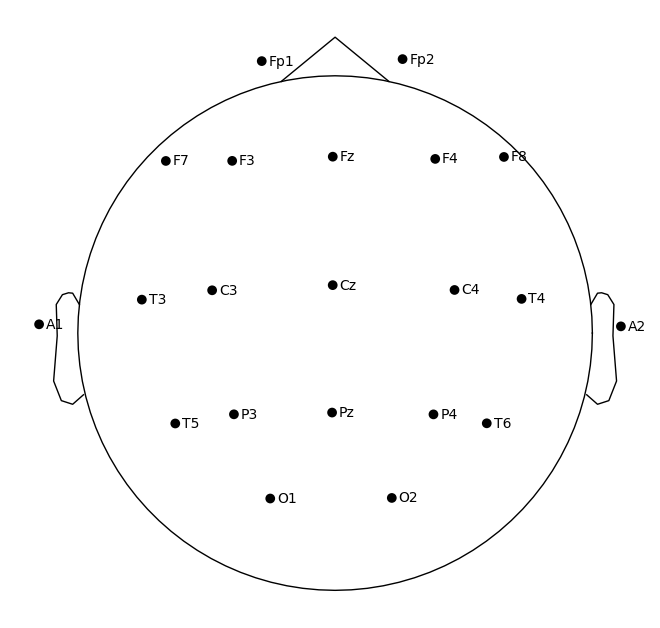

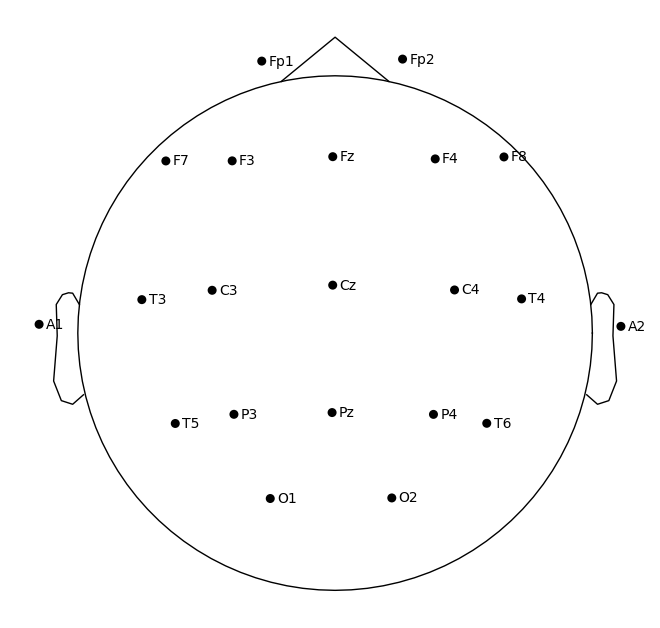

In [65]:
# Form the 10-20 montage
mont1020 = mne.channels.make_standard_montage('standard_1020')
# Choose what channels you want to keep 
# Make sure that these channels exist e.g. T1 does not exist in the standard 10-20 EEG system!
kept_channels = ch_names
ind = []
kept_channels = [ch.lower() for ch in kept_channels]
for i, channel in enumerate(mont1020.ch_names):
    if channel.lower() in kept_channels:
        ind.append(i)
#ind = [i for (i, channel) in enumerate(mont1020.ch_names) if channel in kept_channels]
mont1020_new = mont1020.copy()
# Keep only the desired channels
mont1020_new.ch_names = [mont1020.ch_names[x] for x in ind]
kept_channel_info = [mont1020.dig[x+3] for x in ind]
# Keep the first three rows as they are the fiducial points information
mont1020_new.dig = mont1020.dig[0:3]+kept_channel_info
#mont1020.plot()
mont1020_new.plot()

In [66]:
# electrode positions for the graph nodes
# based on the international 10-20 system
node_positions = {'FP1': (-0.4, 0.45), 'FP2': (0.4, 0.45),
                  'F7': (-1.25, 0.33), 'F3': (-0.65, 0.255),
                  'FZ': (0.0, 0.225), 'F4': (0.65, 0.255),
                  'F8': (1.25, 0.33), 'T3': (-1.5, 0.0),
                  'C3': (-0.75, 0.0), 'CZ': (0.0, 0.0),
                  'C4': (0.75, 0.0), 'T4': (1.5, 0.0),
                  'T5': (-1.25, -0.33), 'P3': (-0.65, -0.255),
                  'PZ': (0.0, -0.225), 'P4': (0.65, -0.255),
                  'T6': (1.25, -0.33), 'O1': (-0.4, -0.45),
                  'O2': (0.4, -0.45),  'A1': (2.0, -0.05),
                  'A2': (-2.0, -0.05)
                 }

nodelist = node_positions.keys()

In [111]:
import matplotlib.pyplot as plt
import networkx as nx
edge_colors = plt.cm.Blues
node_colors = 'red'


def plot_graph(G, ax, add_edge_labels=False):
    #plt.figure(figsize=(7,7))

    # plot nodes
    nx.draw_networkx_nodes(G,
                           node_positions,
                           nodelist=nodelist,
                           node_size=800, 
                           node_color=node_colors,
                           alpha=0.7,
                           ax=ax)

    # plot node labels
    nx.draw_networkx_labels(G,
                            node_positions,
                            labels=dict(zip(nodelist, nodelist)),
                            font_color='white',
                            font_size=14,
                            font_weight='bold',
                            ax=ax
                           )
    
    edge_weights = nx.get_edge_attributes(G,'weight')
    
    # plot edges
    plt_graph_obj = nx.draw_networkx_edges(
        G, node_positions,
        edge_cmap=edge_colors,
        arrows=True,
        width=3,
        arrowsize = 15,
        connectionstyle='arc3, rad = 0.1',
        edge_color=[G[u][v]['weight'] for u, v in G.edges],
        ax=ax
    )
    
    # plot edge labels (weights)
    if add_edge_labels:
        edge_labels = nx.draw_networkx_edge_labels(
            G, node_positions,
            edge_labels=edge_weights,
            label_pos=0.5,
            ax=ax
        )
    
#Ref: https://github.com/Jonkil/OSLOMET_Thesis2022_DS

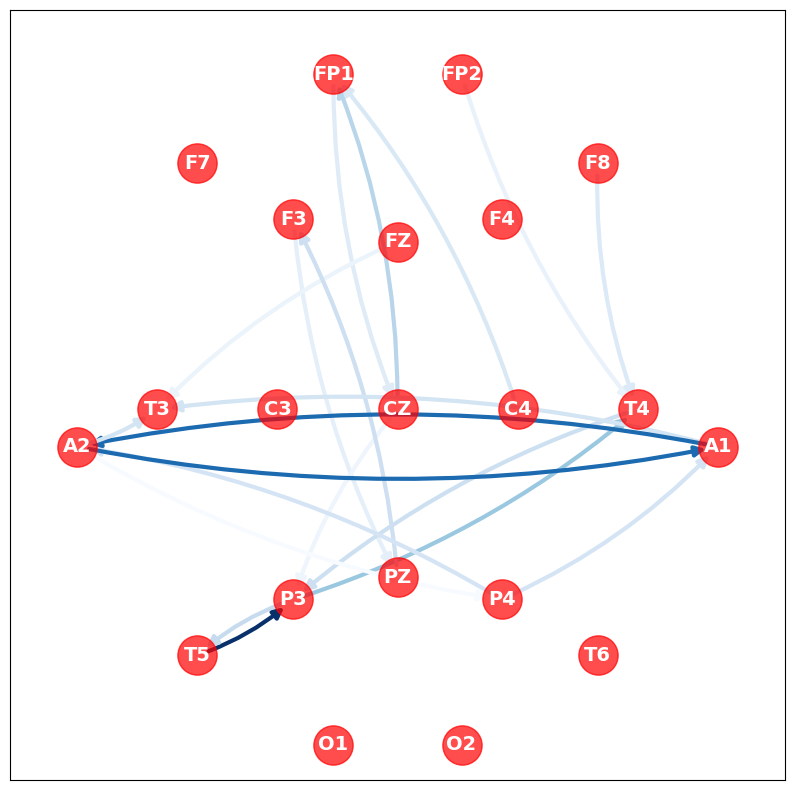

In [749]:
from scipy.stats import iqr
#int_mask_2 = int_mask_2*-1
mask_values = sorted(int_mask_2.flatten(), reverse=True)[20]#int_mask_2.max()*0.2
X1 = nx.DiGraph()
X1.add_nodes_from(node_positions.keys())

for n, p in node_positions.items():
    X1.nodes[n]['pos'] = p

for i, ch1 in enumerate(ch_names):
    for j, ch2 in enumerate(ch_names):
        if int_mask_2[i, j] > mask_values:
            if i != j:
                X1.add_edge(ch1, ch2, weight=int_mask_2[i, j])

fig, ax = plt.subplots(figsize=(10,10))

plot_graph(X1, ax, add_edge_labels=False)
fig.savefig("sub2_int_mask_0_7.pdf", bbox_inches='tight')

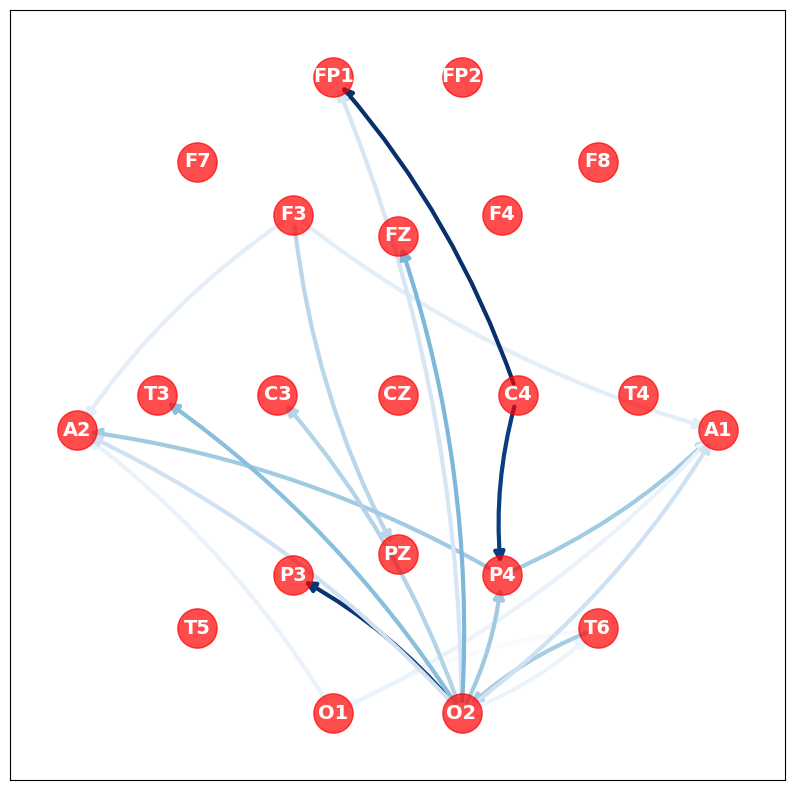

In [750]:
mask_values = sorted(saliency_mask_2.flatten(), reverse=True)[20] #saliency_mask_2.max()*0.7
X2 = nx.DiGraph()
X2.add_nodes_from(node_positions.keys())

for n, p in node_positions.items():
    X2.nodes[n]['pos'] = p

for i, ch1 in enumerate(ch_names):
    for j, ch2 in enumerate(ch_names):
        if saliency_mask_2[i, j] > mask_values:
            if i != j:
                X2.add_edge(ch1, ch2, weight=saliency_mask_2[i, j])

fig, ax = plt.subplots(figsize=(10,10))

plot_graph(X2, ax, add_edge_labels=False)
fig.savefig("sub2_saliency_mask_0_7.pdf", bbox_inches='tight')

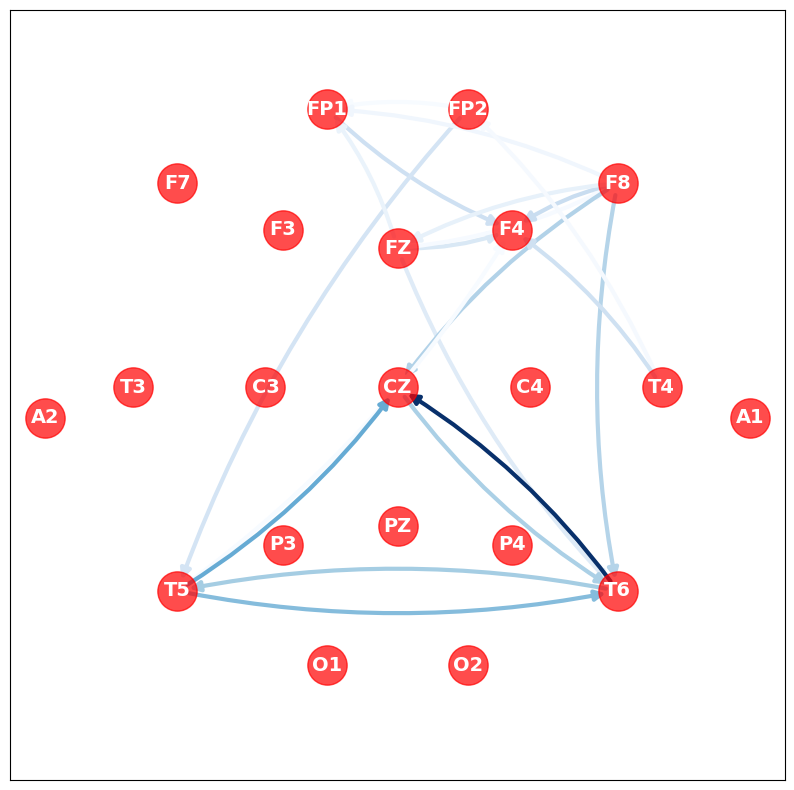

In [753]:
mask_values = sorted(saliency_mask_2032.flatten(), reverse=True)[20]
X3 = nx.DiGraph()
X3.add_nodes_from(node_positions.keys())

for n, p in node_positions.items():
    X3.nodes[n]['pos'] = p

for i, ch1 in enumerate(ch_names):
    for j, ch2 in enumerate(ch_names):
        if saliency_mask_2032[i, j] > mask_values:
            if i != j:
                X3.add_edge(ch1, ch2, weight=saliency_mask_2032[i, j])

fig, ax = plt.subplots(figsize=(10,10))

plot_graph(X3, ax, add_edge_labels=False)
fig.savefig("sub2032_saliency_mask_0_7.pdf", bbox_inches='tight')

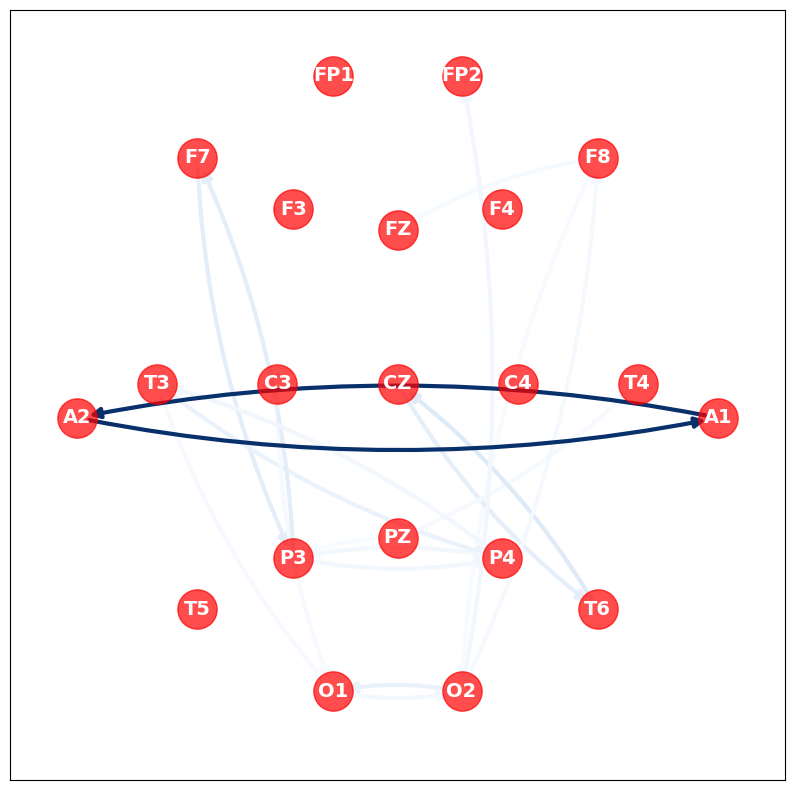

In [754]:
mask_values = sorted(int_mask_2032.flatten(), reverse=True)[20]

X = nx.DiGraph()
X.add_nodes_from(node_positions.keys())

for n, p in node_positions.items():
    X.nodes[n]['pos'] = p

for i, ch1 in enumerate(ch_names):
    for j, ch2 in enumerate(ch_names):
        if int_mask_2032[i, j] > mask_values:
            if i != j:
                X.add_edge(ch1, ch2, weight=int_mask_2032[i, j])

fig, ax = plt.subplots(figsize=(10,10))

plot_graph(X, ax, add_edge_labels=False)
fig.savefig("sub2032_int_mask_0_7.pdf", bbox_inches='tight')

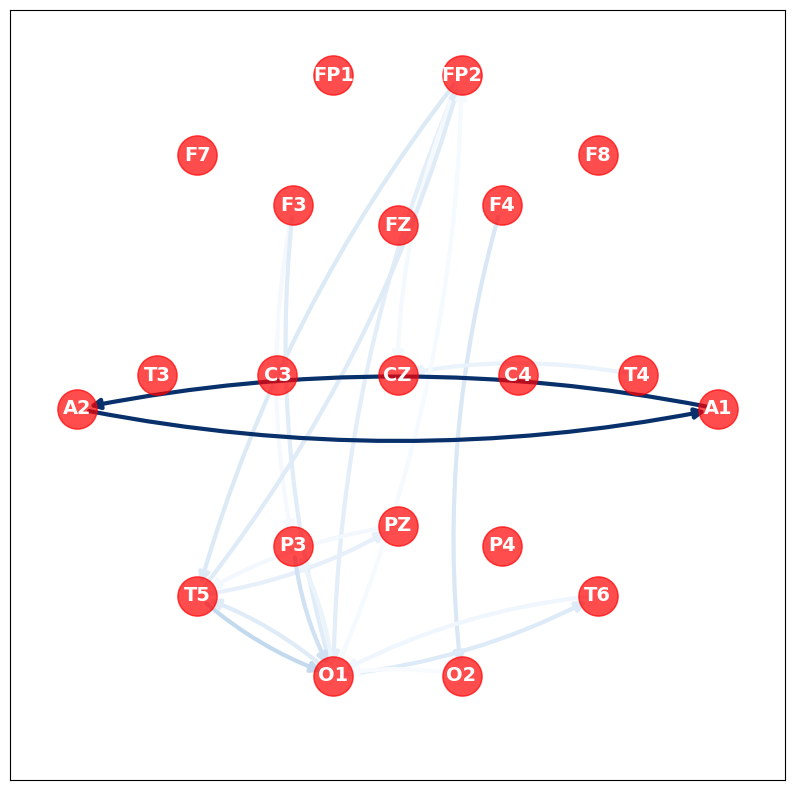

In [761]:
mask_values = sorted(saliency_mask_55.flatten(), reverse=True)[20]
X5 = nx.DiGraph()
X5.add_nodes_from(node_positions.keys())

for n, p in node_positions.items():
    X2.nodes[n]['pos'] = p

for i, ch1 in enumerate(ch_names):
    for j, ch2 in enumerate(ch_names):
        if saliency_mask_55[i, j] > mask_values:
            if i != j:
                X5.add_edge(ch1, ch2, weight=saliency_mask_55[i, j])

fig, ax = plt.subplots(figsize=(10,10))

plot_graph(X5, ax, add_edge_labels=False)
fig.savefig("sub55_saliency_mask_0_7.pdf", bbox_inches='tight')

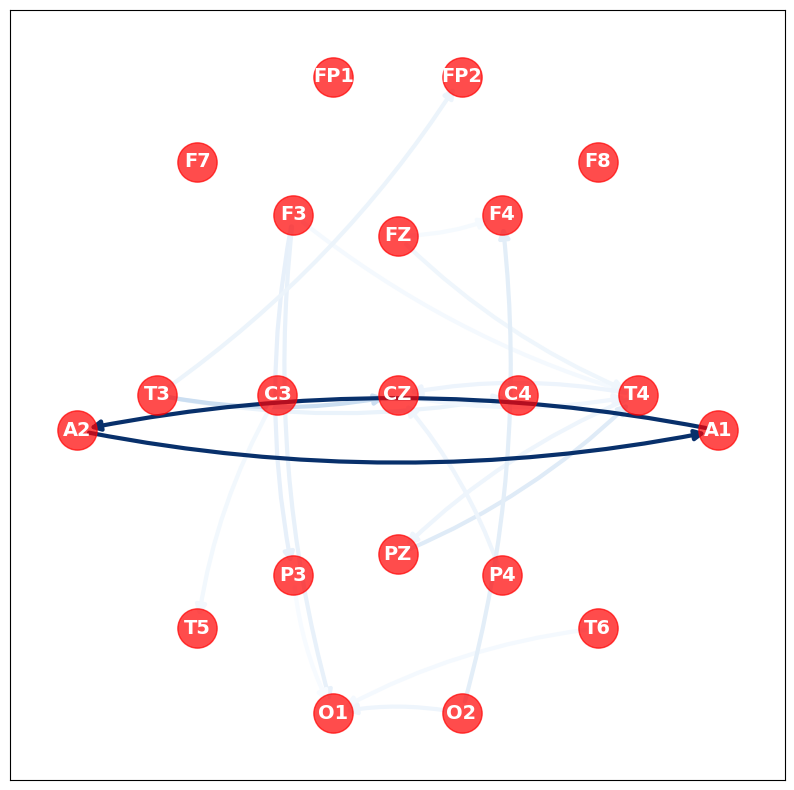

In [770]:
int_mask_55 = int_mask_55*-1
mask_values = sorted(int_mask_55.flatten(), reverse=True)[20]
X6 = nx.DiGraph()
X6.add_nodes_from(node_positions.keys())

for n, p in node_positions.items():
    X6.nodes[n]['pos'] = p

for i, ch1 in enumerate(ch_names):
    for j, ch2 in enumerate(ch_names):
        if int_mask_55[i, j] > mask_values:
            if i != j:
                X6.add_edge(ch1, ch2, weight=int_mask_55[i, j])

fig, ax = plt.subplots(figsize=(10,10))

plot_graph(X6, ax, add_edge_labels=False)
fig.savefig("sub55_int_mask_0_7.pdf", bbox_inches='tight')

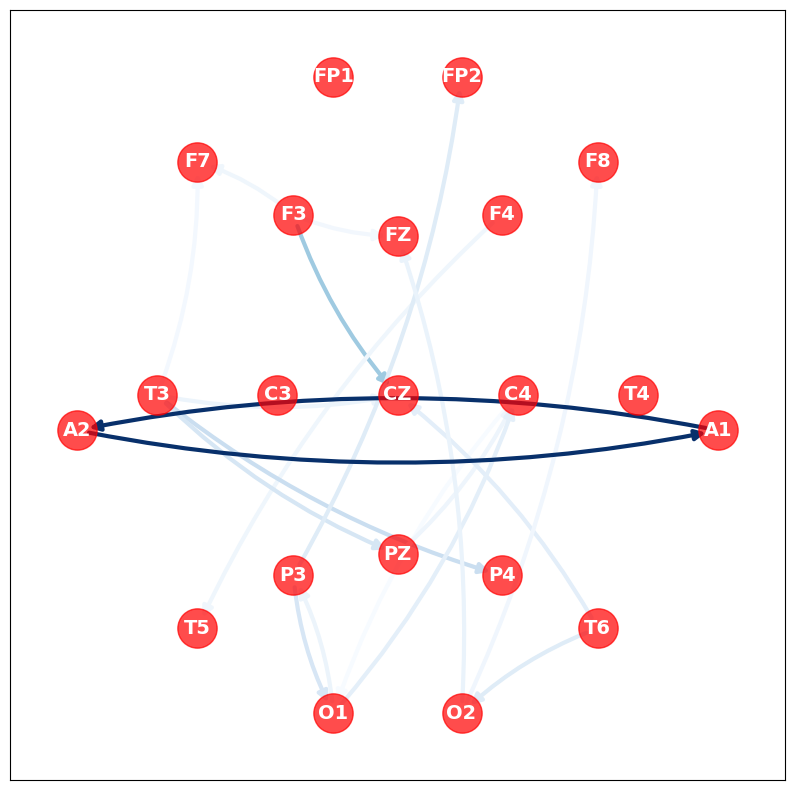

In [777]:
#int_mask_2000 = int_mask_2000*-1
mask_values = sorted(int_mask_2000.flatten(), reverse=True)[20]
X6 = nx.DiGraph()
X6.add_nodes_from(node_positions.keys())

for n, p in node_positions.items():
    X6.nodes[n]['pos'] = p

for i, ch1 in enumerate(ch_names):
    for j, ch2 in enumerate(ch_names):
        if int_mask_2000[i, j] > mask_values:
            if i != j:
                X6.add_edge(ch1, ch2, weight=int_mask_2000[i, j])

fig, ax = plt.subplots(figsize=(10,10))

plot_graph(X6, ax, add_edge_labels=False)
fig.savefig("sub2000_int_mask_0_7.pdf", bbox_inches='tight')

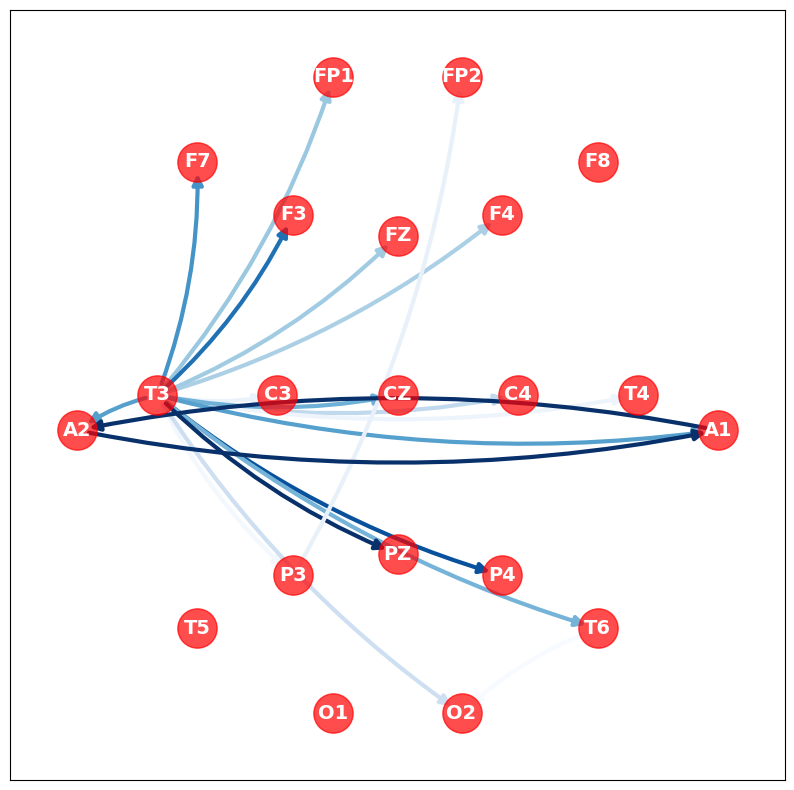

In [778]:
mask_values = sorted(saliency_mask_2000.flatten(), reverse=True)[20]
X6 = nx.DiGraph()
X6.add_nodes_from(node_positions.keys())

for n, p in node_positions.items():
    X6.nodes[n]['pos'] = p

for i, ch1 in enumerate(ch_names):
    for j, ch2 in enumerate(ch_names):
        if saliency_mask_2000[i, j] > mask_values:
            if i != j:
                X6.add_edge(ch1, ch2, weight=saliency_mask_2000[i, j])

fig, ax = plt.subplots(figsize=(10,10))

plot_graph(X6, ax, add_edge_labels=False)
fig.savefig("sub2000_saliency_mask_0_7.pdf", bbox_inches='tight')

## Global Saliency and Int Gradent Maps

In [35]:
int_masks = []
saliency_masks = []
for idx in tqdm(range(len(train_data_files))):
    int_mask=build_maps(method="ig", subject_idx=idx)
    saliency_mask=build_maps(method="saliency", subject_idx=idx)
    saliency_masks.append(saliency_mask)
    int_masks.append(int_mask)

100%|█████████████████████████████████████████████████████████████| 2232/2232 [00:39<00:00, 56.22it/s]


In [37]:
saliency_masks = np.array(saliency_masks)
saliency_masks_average = np.mean(saliency_masks, axis=0)
saliency_masks_average.shape

(21, 21)

In [43]:
int_masks = np.array(int_masks)
int_masks_average = np.mean(int_masks, axis=0)
int_masks_average.shape

(21, 21)

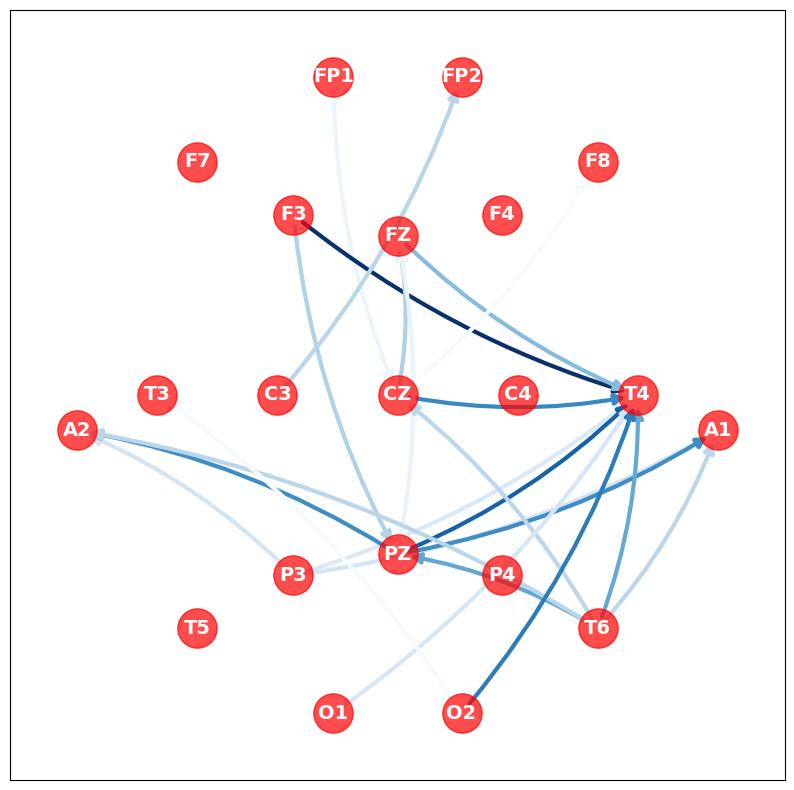

In [54]:
mask_values = sorted(saliency_masks_average.flatten(), reverse=True)[25]
X11 = nx.DiGraph()
X11.add_nodes_from(node_positions.keys())

for n, p in node_positions.items():
    X11.nodes[n]['pos'] = p

for i, ch1 in enumerate(ch_names):
    for j, ch2 in enumerate(ch_names):
        if sorted(saliency_masks_average.flatten(), reverse=True)[1] > saliency_masks_average[i, j] > mask_values:
            if i != j:
                X11.add_edge(ch1, ch2, weight=saliency_masks_average[i, j])

fig, ax = plt.subplots(figsize=(10,10))

plot_graph(X11, ax, add_edge_labels=False)
fig.savefig("glob_saliency_mask_0_7.pdf", bbox_inches='tight')

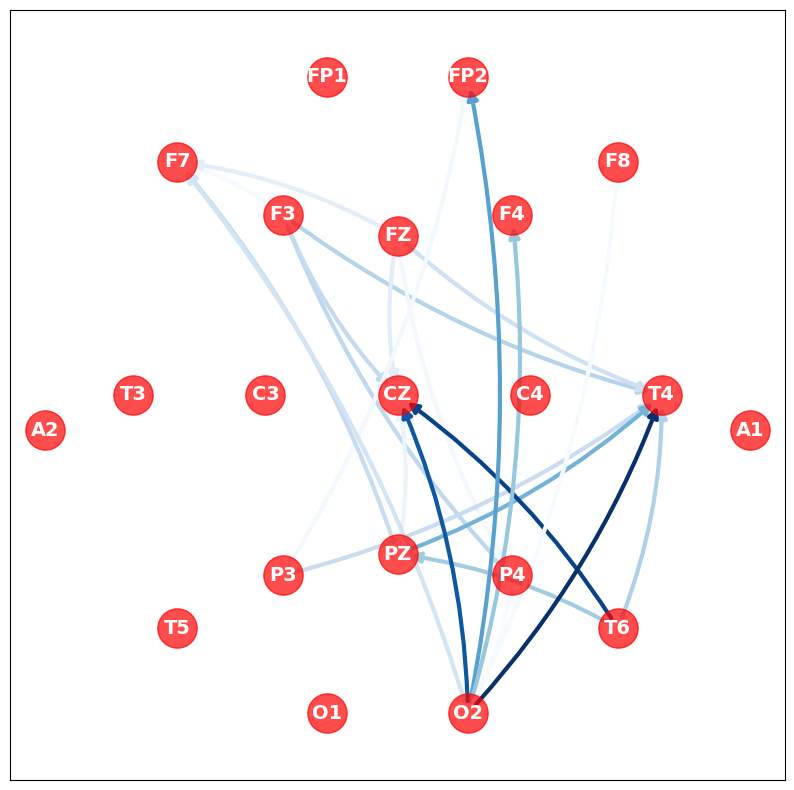

In [55]:
mask_values = sorted(int_masks_average.flatten(), reverse=True)[25]
X12 = nx.DiGraph()
X12.add_nodes_from(node_positions.keys())

for n, p in node_positions.items():
    X12.nodes[n]['pos'] = p

for i, ch1 in enumerate(ch_names):
    for j, ch2 in enumerate(ch_names):
        if sorted(int_masks_average.flatten(), reverse=True)[1] > int_masks_average[i, j] > mask_values:
            if i != j:
                X12.add_edge(ch1, ch2, weight=int_masks_average[i, j])

fig, ax = plt.subplots(figsize=(10,10))

plot_graph(X12, ax, add_edge_labels=False)
fig.savefig("glob_int_mask_0_7.pdf", bbox_inches='tight')